In [20]:
import os

import clean
import matplotlib.pyplot as plt
import numpy as np

os.environ["KERAS_BACKEND"] = "jax"
import keras
import keras_tuner
from keras import layers

In [4]:
splits = clean.get_base_splits()
i_train, i_tune, i_test, t_train, t_tune, t_test = (
    splits[part]
    for part in ["i_train", "i_tune", "i_test", "t_train", "t_tune", "t_test"]
)

In [5]:
input_norm = layers.Normalization(
    axis=-1, mean=i_train.mean(axis=0), variance=i_train.var(axis=0)
)

output_denorm = layers.Normalization(
    axis=-1,
    invert=True,
    mean=t_train.mean(axis=0),
    variance=t_train.var(axis=0),
)
example_model = keras.Sequential(
    [
        layers.Input((4,), batch_size=50),
        input_norm,
        layers.Dense(4, activation="relu", name="layer1"),
        layers.Dense(1, name="layer2"),
        output_denorm,
    ]
)

example_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.losses.MeanAbsolutePercentageError()],
)
example_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (50, 4)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (50, 4)                │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (50, 1)                │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (50, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
def directly_weighted_mse(y_true, y_pred):
    return keras.ops.mean(((y_true - y_pred) * (y_true / t_train.mean())) ** 2)

In [52]:
def build_model(hp: keras_tuner.HyperParameters):
    model = keras.Sequential(
        [layers.Input((4,), batch_size=50, name="input")], name="prediction_model"
    )

    if hp.Boolean("normalize_input"):
        model.add(input_norm)

    if hp.Boolean("denormalize_output"):
        model.add(output_denorm)

    for i in range(hp.Int("num_layers", 1, 5, step=1)):
        model.add(
            layers.Dense(
                hp.Int(f"units_{i}", 10, 100, step=10),
                activation=hp.Choice("activation_type", ["relu", "tanh"]),
                name=f"layer_{i}",
            )
        )

        if hp.Boolean("dropout"):
            model.add(layers.Dropout(hp.Float("dropout_rate", 0.05, 0.35, step=0.1)))

    model.add(
        layers.Dense(1, name="output"),
    )

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=directly_weighted_mse,
        metrics=["mape", "mse"],
    )
    return model

In [14]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=2,
    overwrite=False,
    seed=1,
    directory="keras_checkpoints",
    project_name="architecture_search_nn",
)
tuner.search_space_summary()

Reloading Tuner from keras_checkpoints/architecture_search_nn/tuner0.json
Search space summary
Default search space size: 10
normalize_input (Boolean)
{'default': False, 'conditions': []}
denormalize_output (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
activation_type (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.35, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 

In [45]:
fit_args = dict(
    x=i_train,
    y=t_train,
    validation_data=(i_tune, t_tune),
    epochs=5,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=1, restore_best_weights=True, monitor="val_loss", mode="min"
        )
    ],
    batch_size=50_000,
)

In [21]:
tuner.search(**fit_args, verbose=False)

In [53]:
best_model = build_model(tuner.get_best_hyperparameters()[0])

history = best_model.fit(**fit_args)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - loss: 7951.5264 - mape: 4739531.0000 - mse: 1484.5552 - val_loss: 2366.6731 - val_mape: 9299004.0000 - val_mse: 2077.4702
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - loss: 2954.2563 - mape: 8151294.0000 - mse: 2287.7271 - val_loss: 2369.7400 - val_mape: 8885665.0000 - val_mse: 1895.6333


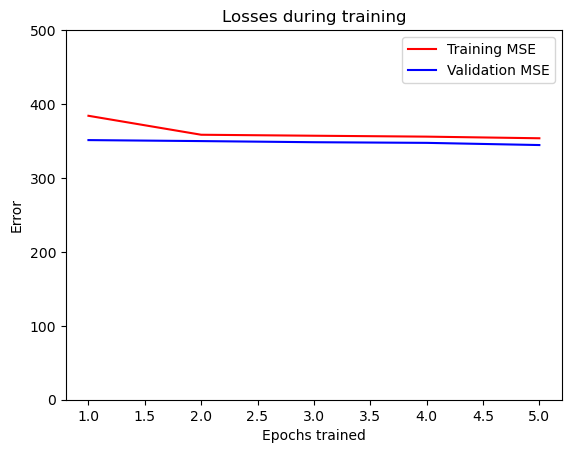

In [24]:
x = range(1, 6)

plt.plot(x, history.history["loss"], color="red", label="Training MSE")

plt.plot(x, history.history["val_loss"], color="blue", label="Validation MSE")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Epochs trained")
plt.ylabel("Error")
plt.ylim((0, 500))
plt.show()

In [40]:
best_model.summary()

Model: "prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (5000, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_0 (Dense)                 │ (5000, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (5000, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (5000, 40)             │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (5000, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (5000, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (5000, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (5000, 10)             │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (5000, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (5000, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,925 (101.27 KB)

 Trainable params: 8,641 (33.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,284 (67.52 KB)

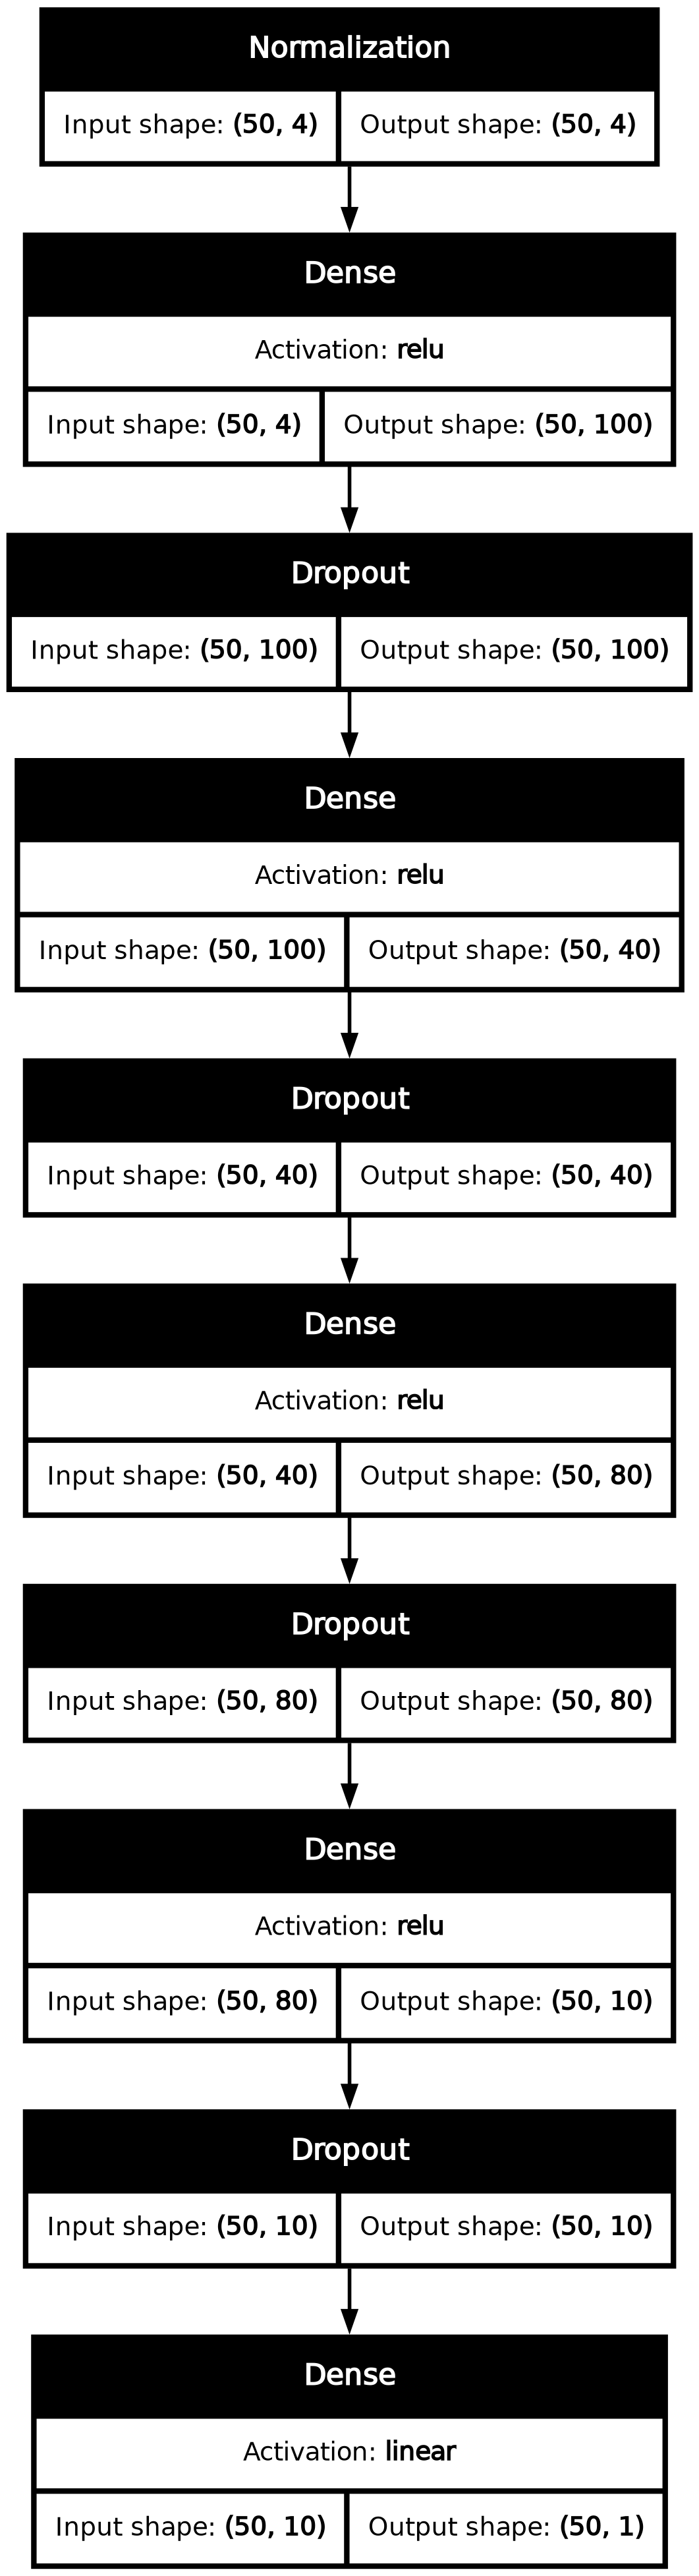

In [55]:
keras.utils.plot_model(
    best_model, show_shapes=True, show_layer_activations=True, to_file="arch.png"
)

In [44]:
np.save(clean.data_dir("pred/base_mse.npy"), best_model(i_test))
print("RMSE:", np.sqrt(best_model.evaluate(x=i_test, y=t_test, batch_size=50_000)[0]))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 346.9073 - mean_absolute_percentage_error: 1995135.0000
RMSE: 18.583949787310168


In [54]:
# Variant with DW MSE loss
print(best_model(i_test[:5]))
np.save(clean.data_dir("pred/base_wgh.npy"), best_model(i_test))
print("RMSE:", np.sqrt(best_model.evaluate(x=i_test, y=t_test, batch_size=50_000)[2]))

[[59.3207  ]
 [55.948105]
 [57.56968 ]
 [61.610394]
 [59.043743]]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2354.0076 - mape: 9327828.0000 - mse: 2077.5635
RMSE: 45.58784874421033
